# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [72]:
# Imports here

import matplotlib.pyplot as plt

import numpy as np
import torch
import json

import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms, models
import torchvision.models as models
import seaborn as sns
from PIL import Image
from matplotlib.ticker import FormatStrFormatter


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets


#with training data, you typically want to do data argumentation ; rotating it,resizing it, flipping it
#to create this simulated dataset of more images than we acually have
#firstly; it just gives us more data to actually train with
#secondly; it helps the network the network generalize to images that aren't in the training set

#combine these transforms into a pipeline of transform using  (transforms.Compose)
train_transforms =transforms.Compose([transforms.RandomRotation(30),      #random rotation with 30 degree
                                       transforms.RandomResizedCrop(224), #random resize crop; randomly resizing the image and then take a crop from the center of 224 pixel square 
                                       transforms.RandomHorizontalFlip(), #random horizontal flip, it's going to mirror it horizontally 
                                       transforms.ToTensor(),           #change it to a tensor 
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])]) 

#notice one thing to remember is that for testing when you're doing your validation, 
#we don't want to do any of this data augmentation
validation_transforms =transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])]) 

test_transforms =transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])]) 

# TODO: Load the datasets with ImageFolder
#after defining our transforms and then you pass that to dataloder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms) #(transform=train_transform) we pass ourdata directories and our transformer through imagefolder and along with the path to our dataset and that creats a "train_data" object 
validation_data = datasets.ImageFolder(valid_dir, transform=validation_transforms) #so on
test_data = datasets.ImageFolder(test_dir ,transform = test_transforms)    #so on
 



# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True) #DataLoader(we can pass train_data to data folder, this will give us back a generator were we actually can get our images and labels and we give our loaded data to our data loaders to actually get our load our datasets
validationloader = torch.utils.data.DataLoader(validation_data, batch_size =32,shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 20, shuffle = True)

#shuffle=True
#what shuffle does is it randomly shuffles your data every time you start anew epoch
#this's useful because when you're training your network we prefer it 
#the second time it goes through to see your images in a different order
#the third time it goes through to see your images in a different order 
#rather than just learning in the same order every time 
#because then this could introduce weird artifacts in how your network is learning from your data 

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [6]:
# TODO: Build and train your network

#load model and use it 
model = models.vgg16(pretrained=True)  #download the pre-trained network, weights and parameter then load it into our model

model # to look at what the architecture of this model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 99094872.58it/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [7]:
# Freeze our features parameters to keep features part static, Freeze training for all "features" layers

for param in model.parameters(): #we go through our parameters in our model
    param.requires_grad = False  #this will do is that when we run our tensor through the model, 
                                #it's not going to calculate the gradients; it is not going to keep track of all these operation 
                               #and also will speed up training because we're not keeping track of these operations for the features  


In [8]:
from collections import OrderedDict
#you can actually pass in in order to dict in order to dictionary to name each of the layers in your Sequential model
#OrderedDict takes in a list of tuples that builds the dictionary keys(the name of our layer like relu1 relu2) and value(operation themself)

classifier = nn.Sequential(OrderedDict([                  #Sequential module; basically give it a list of different operations you want to do and then it will automatically pass a tensor through them sequentially
                          ('fc1', nn.Linear(25088, 200)), #The number of input features on line (0) with a value of 25088 must also be the same as our first input layer.
                          ('relu1', nn.ReLU()),
                          ('Dropout', nn.Dropout(0.5)), # we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data
                          ('fc2', nn.Linear(200, 150)),
                          ('relu2', nn.ReLU()),
                          ('Dropout', nn.Dropout(0.2)),
                          ('fc3', nn.Linear(150, 90)),
                          ('relu3', nn.ReLU()),
                          ('Dropout', nn.Dropout(0.2)),
                          ('fc4', nn.Linear(90, 102)),
                          ('output', nn.LogSoftmax(dim=1)) #(dim=1) this makes it so that it calculates the function across the columns instead of the rows
                          ]))                              # output so no dropout here

model.classifier = classifier

In [9]:
model.to(device); 
#if you need to move a model to GPU via .cuda(), 
#please do so before constructing optimizers for it. 
#Parameters of a model after .cuda() will be different objects with those before the call.

Define [the criterion](http://pytorch.org/docs/master/nn.html#loss-functions) (something like `nn.CrossEntropyLoss` or `nn.NLLLoss`) and [the optimizer](http://pytorch.org/docs/master/optim.html) (typically `optim.SGD` or `optim.Adam`).

In [10]:
# Define the loss and the optimize

criterion = nn.NLLLoss()
#With a log-softmax output, you want to use the negative log likelihood loss, nn.NLLLoss

optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)
#Optimizers require for the last layer which we replace; the parameters to optimize and a learning rate
#optim.Adam this's basically the same as stochastic gradient descent, but it has some nice properties where it uses momentum which speeds up the actual fitting process
#and it also adjust the learning rate for each of the individual parameters in your model

In [12]:
epochs = 12
steps = 0         #tracking the numbel of train steps we do
running_loss = 0 #tracking the loss with running loss
print_every = 5 #how many steps we're going to go before we print out the validation loss
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1   #cumulate steps; every time we go through one of these batches, we're going to increment steps here 
        inputs, labels = inputs.to(device), labels.to(device) #similarly; if you want to run your inputs through your model, you have to make sure that the tensors that you're putting trough your model or on the GPU if your model's on the GPU 
        
        optimizer.zero_grad()            # Clear the gradients, do this because gradients are accumulated.before every training passes

# Forward pass, then backward pass, then update weights

        logps = model.forward(inputs)    #(log probability) to take maximum probability and get minimizing cross entropy;  Forward pass,get our log-probabilities; get our probability by passing in the inputs to a model
        loss = criterion(logps, labels)  #Calculate the loss with the logps and the labels
        loss.backward()                  #we'll do our backwards pass starting from the loss , so we can look at the weight and then we can look at the weight gradients, we can use these gradients in gradint descent to train our network
        optimizer.step()                 #Take an update step and few the new weights

        running_loss += loss.item()      #we can increment are running loss; this way we can keep track of our training loss
        

#after each epochs, after each pass through the training set, then we're going to do a validation pass
#after the above loop complete , run the below code

#we actually want to drop out of the train loop and test our network accuracy and loss on our test dataset
        if steps % print_every == 0:  #then we're going to go into our validation loop
            model.eval()             #turns our model into evaluation inference mode which turns off dropout                                                
            test_loss = 0
            accuracy =0
            with torch.no_grad():                            # Turn off gradients for validation, saves memory and computations and to speed up this part
                for inputs, labels in testloader:           #get our inputs and labels from testset
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)             #pass images into our model to get our logprobabilities 
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()  #this way allow us to keep track our test loss as we're going through these validation rules
                    
# Calculate accuracy
                    ps = torch.exp(logps)                               #get actual probability distributions from logprobabilities
                    top_p, top_class = ps.topk(1, dim=1)                #give us the top class or prediction class from network; first largest value in our probabilities along the columns

#top_k actually returns a tuple with two tensors
#the first tensor (top_p) actually probability and the second tensor(top_class) are the class indices themselves
#i'm calling (topk) and i'm separating out the probabilities in the classes
#so, we will just use this top class going forward        
         
                    equals = top_class == labels.view(*top_class.shape)            #checking for equality, we can see where our predicted classes match with the true classes from labels; equals should have same shape
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()  #equals has type torch.ByteTensor so we have to convert equals to a float tensor
#basically; we've a running loss of our training loss of our training loss 
#and we've a test loss that we passed our test data through our model and measured the loss in accuracy                
                
                print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            
            running_loss = 0
            
            model.train()                                             #to set model back into train mode which turns on dropout

Epoch 1/12.. Train loss: 4.672.. Test loss: 4.469.. Test accuracy: 0.076
Epoch 1/12.. Train loss: 4.468.. Test loss: 4.314.. Test accuracy: 0.082
Epoch 1/12.. Train loss: 4.399.. Test loss: 4.156.. Test accuracy: 0.104
Epoch 1/12.. Train loss: 4.146.. Test loss: 3.945.. Test accuracy: 0.122
Epoch 1/12.. Train loss: 4.029.. Test loss: 3.686.. Test accuracy: 0.181
Epoch 1/12.. Train loss: 3.883.. Test loss: 3.532.. Test accuracy: 0.203
Epoch 1/12.. Train loss: 3.583.. Test loss: 3.283.. Test accuracy: 0.250
Epoch 1/12.. Train loss: 3.541.. Test loss: 3.119.. Test accuracy: 0.245
Epoch 1/12.. Train loss: 3.466.. Test loss: 2.938.. Test accuracy: 0.287
Epoch 1/12.. Train loss: 3.297.. Test loss: 2.825.. Test accuracy: 0.283
Epoch 1/12.. Train loss: 3.035.. Test loss: 2.683.. Test accuracy: 0.335
Epoch 1/12.. Train loss: 3.072.. Test loss: 2.617.. Test accuracy: 0.353
Epoch 1/12.. Train loss: 2.839.. Test loss: 2.549.. Test accuracy: 0.356
Epoch 1/12.. Train loss: 3.025.. Test loss: 2.424..

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [13]:
# TODO: Do validation on the test set
def check_accuracy_on_test(testloader):    
    correct = 0
    total = 0
    model.to(device);
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) # convert output probabilities to predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    
check_accuracy_on_test(testloader)

Accuracy of the network on the test images: 73 %


In [14]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

**Notice to learn how to save and load the model seel the** [documents](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save)

In [15]:
# TODO: Save the checkpoint 
model.class_to_idx = train_data.class_to_idx #keeps track of our mapping of flower class values to the flower indices, where the indices are actually predicted by our model
model.cpu

checkpoint= {
            'epoch': epochs,
            'model_state_dict': model.state_dict(), #holds all of the weights and biases of our model for each layer in a dictionary
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'class_to_idx':model.class_to_idx}

torch.save(checkpoint, 'checkpoint.pth')  #this funcion takes two arguments: a dictionary and a path of where to save the dictionary.

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [11]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

#To load the items, first initialize the model and optimizer
#function that makes it easy to load the state_dict you saved earlier.

def load_model(path):
    checkpoint = torch.load('checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    model.class_to_idx = checkpoint['class_to_idx'] 

model.eval()    #to set dropout and batch normalization layers to evaluation mode before running inference
model.train()    #to ensure these layers are in training mode.

load_model('checkpoint.pth') 
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

**Notice**

**starting from here, i didn't find any thing in the lessons or Notebooks, so i've searched on the web to get some help and i've learnt form this article by Josh Bernhard [medium](https://medium.com/@josh_2774/deep-learning-with-pytorch-9574e74d17ad)**

In [13]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    
    img = Image.open(image_path) # Open the image
    
    # Resize
    #we needed to resize the images where the shortest side is 256 pixels
    #Using thumbnail meant that I could look at which of the (width, height) was smaller, then fix this value to 256 pixels
    
    if img.size[0] > img.size[1]:         #(if the width > height)
        img.thumbnail((10000, 256))      #constrain the height to be 256
    else:
        img.thumbnail((256, 10000))      #otherwise constrain the width
        
    # Crop method of the image
    #which takes a tuple holding the (left_margin, bottom_margin, right_margin, top_margin)
    
    left_margin = (img.width-224)/2      #just taking the total width subtracting 224, and then dividing by two since we want the remaining amount to be split to be used equally on each margin.
    right_margin = left_margin + 224
    
    
    bottom_margin = (img.height-224)/2   #just taking the total height subtracting 224, and then dividing by two since we want the remaining amount to be split to be used equally on each margin.
    top_margin = bottom_margin + 224
    
    img = img.crop((left_margin, bottom_margin, right_margin,   
                       top_margin))
   
    img = np.array(img)/255 #Color channels of images are typically encoded as integers 0–255, but the model expected floats 0–1. We can make this change by scaling by 255.
    
    # Normalize
    #we want to normalize in the way expected by our model, which means subtracting out the image mean values and dividing by the standard deviation in each direction.
    
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

you want to be able to pass an individual image to your deep learning network, and for your network to predict the label for the image.

In [59]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
   
    image = image.transpose((1, 2, 0)) #we will want to move the third index of our images to the first, and shift the other two indices.
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225])  #provided std
    
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


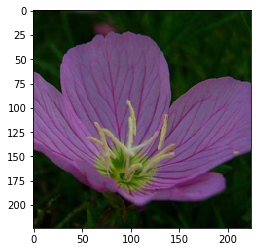

In [60]:
image_path = (data_dir + '/test' + '/1/' + 'image_06752.jpg')
img = process_image(image_path)
imshow(img)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

we want to write a function we can use without firing up a gpu and on the single image we returned using the above process_image function.

In [68]:
model = model.to('cpu')

In [69]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)   ## make image pytorch compatible
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor) #we need to change our numpy array to a PyTorch tensor
    model_input = image_tensor.unsqueeze(0) #it is suggested that we can use img.unsqueeze_(0) to add a 1 as the first argument of our tensor.
                                            #Now, the shape of our img is (1, 3, 224, 224), which corresponds to the (batch_size, rgb, width, height).
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0]  #Those later broke because they were not hashable, so I added tolist().
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    #we wanted to switch the direction of the key, val to be able to index using what was provided back from the model to pull the class number.
    
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()} #We can flip the key, val for the dictionary
    
    top_labels = [idx_to_class[lab] for lab in top_labs]      #Then to pull the top classes we need to index the idx_to_class with the top_labs values
    
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]  #it would be more useful to return the flower name
    
    return top_probs, top_labels, top_flowers

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [73]:
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    flower_num = image_path.split('/')[2]
    title_ = cat_to_name[flower_num]
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()
    

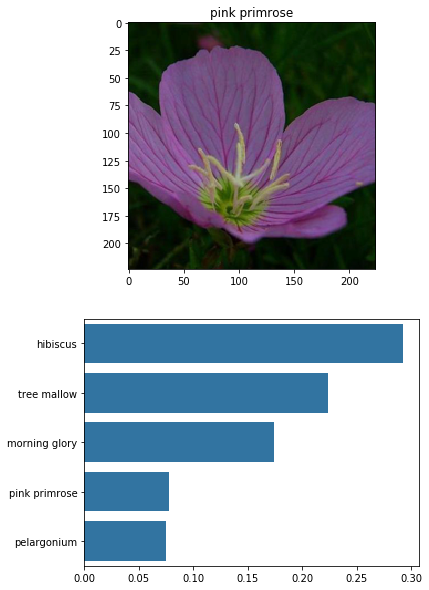

In [74]:
image_path =data_dir + '/test/1/image_06752.jpg'
plot_solution(image_path,model) 


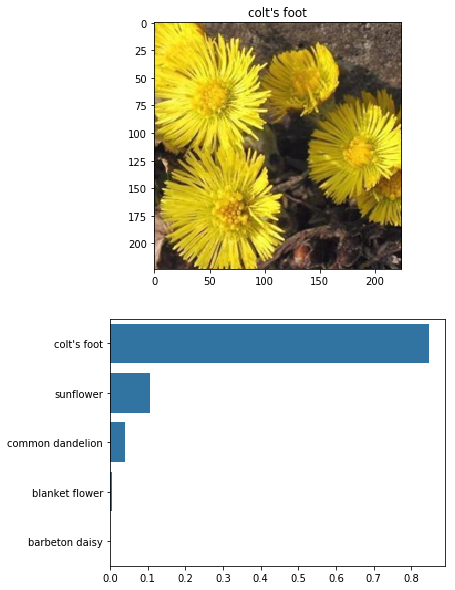

In [75]:
image_path =data_dir + '/test/12/image_04077.jpg'
plot_solution(image_path,model) 

